# Notebook: Sistem Pendukung Investigasi Serangan Siber Berdasarkan Log Server Web dan Bisecting K-Means

Notebook ini membangun sistem analisis log server web untuk investigasi serangan siber, dengan pipeline:
1. Import library & setup lingkungan
2. Membaca & membersihkan data log
3. Ekstraksi & tokenisasi URL
4. Pembuatan embedding URL dengan BERT
5. Clustering URL menggunakan Bisecting K-Means
6. Visualisasi & analisis hasil cluster

## 1. Import Library dan Setup Lingkungan

Impor semua library yang diperlukan (pandas, numpy, torch, transformers, sklearn, dsb). Lakukan setup device (CPU/GPU) dan inisialisasi model/tokenizer BERT.

In [9]:
import os
import re
import sys
import torch
import argparse
import numpy as np
import pandas as pd
from urllib.parse import urlparse, unquote
from transformers import BertTokenizer, BertModel
from sklearn.feature_extraction.text import HashingVectorizer
# from gensim.models import FastText
from sklearn.cluster import BisectingKMeans, KMeans
from sklearn.preprocessing import normalize, OneHotEncoder, MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from decoder import parse_dec_file_to_dataframe
from pprint import pprint

# Select GPU if available, otherwise fallback to CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load tokenizer and model ONCE globally for efficiency
TOKENIZER = BertTokenizer.from_pretrained("bert-base-uncased")
MODEL = BertModel.from_pretrained("bert-base-uncased").to(device)
MODEL.eval()

# Important Variables
input_log_file = "../inputs/sample.log"
output_dir = "../outputs/sample.csv"
num_clusters = 8

Using device: cpu


c:\Users\rizky\.conda\envs\skripsi\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\rizky\.cache\huggingface\hub\models--bert-base-uncased. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP downloa

## 2. Membaca dan Membersihkan Data Log

Baca file log hasil decoding (menggunakan fungsi dari `decoder.py`), filter bot, dan parsing menjadi DataFrame yang siap diolah.

In [17]:
# Load and process log file
df = parse_dec_file_to_dataframe(input_log_file)
print(f"✅ Loaded {len(df)} rows from {input_log_file}")
df.head()

✅ Loaded 61 rows from ../inputs/sample.log


,ip,time,method,url,protocol,status,size,referrer,user_agent,extra,no
0,31.56.96.51,2019-01-22 00:26:16+00:00,GET,/image/60844/productModel/200x200,HTTP/1.1,200,5667,https://www.zanbil.ir/m/filter/b113,Mozilla/5.0 (Linux; Android 6.0; ALE-L21 Build...,-,2
1,31.56.96.51,2019-01-22 00:26:16+00:00,GET,/image/61474/productModel/200x200,HTTP/1.1,200,5379,https://www.zanbil.ir/m/filter/b113,Mozilla/5.0 (Linux; Android 6.0; ALE-L21 Build...,-,3
2,91.99.72.15,2019-01-22 00:26:17+00:00,GET,/product/31893/62100/سشوار-خانگی-پرنسلی-مدل-PR...,HTTP/1.1,200,41483,-,Mozilla/5.0 (Windows NT 6.2; Win64; x64; rv:16...,-,5
3,178.253.33.51,2019-01-22 00:26:19+00:00,GET,/m/product/32574/62991/ماشین-اصلاح-صورت-پرنسلی...,HTTP/1.1,200,20406,"https://www.zanbil.ir/m/filter/p5767,t156?name...",Mozilla/5.0 (Linux; Android 5.1; HTC Desire 72...,-,13
4,91.99.72.15,2019-01-22 00:26:19+00:00,GET,/product/10075/13903/مایکروفر-رومیزی-سامسونگ-م...,HTTP/1.1,200,41725,-,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...,-,15


## 3. Ekstraksi dan Tokenisasi Fitur

Ekstrak fitur dari log, lakukan masking angka pada fitur URL, kategorisasi fitur status, dan tokenisasi path serta query string menjadi token-token teks.

In [ ]:
# def extract_unique_urls(df):
#     """
#     Extract unique URLs from the dataframe and mask numeric values.

#     Args:
#         df (pd.DataFrame): Dataframe containing a 'url' column.

#     Returns:
#         list: Unique URLs where numeric sequences are replaced with <NUM>.
#     """
#     result = df['url'].unique()
#     result = [re.sub(r'\d+', '<NUM>', url) for url in result]
#     return list(dict.fromkeys(result))

def mask_numbers(url):
    """
    Replace numeric sequences in a URL with a placeholder token <NUM>.

    Args:
        url (str): A URL string that may contain numeric sequences.

    Returns:
        str: The URL string where all numeric sequences are replaced with <NUM>.
    """
    return re.sub(r'\d+', '<NUM>', url)



def split_url_tokens(url):
    """
    Tokenize a URL by splitting its path and query string.

    Args:
        url (str): A URL string to tokenize.

    Returns:
        list: List of token strings extracted from the URL.
    """
    parsed = urlparse(url)
    path = unquote(parsed.path)
    query = unquote(parsed.query)
    delimiters = r"[\/\-\_\=\&\?\.\+\(\)\[\]\<\>\{\}]"
    tokens = re.split(delimiters, path.strip("/")) + re.split(delimiters, query)
    return [tok for tok in tokens if tok]


def tokenize_user_agent(ua):
    """
    Tokenize a User-Agent string by splitting on common delimiters.

    Args:
        ua (str): User-Agent string.

    Returns:
        list: List of tokens such as browser, OS, and engine identifiers.
    """
    tokens = re.split(r"[ /;()]+", ua)
    return [tok for tok in tokens if tok]


def categorize_status(code):
    """
    Categorize HTTP status codes into standard ranges.

    Args:
        code (int): HTTP status code.

    Returns:
        str: Category label ("2xx", "3xx", "4xx", "5xx", or "other").
    """
    if 200 <= code < 300:
        return "2xx"
    elif 300 <= code < 400:
        return "3xx"
    elif 400 <= code < 500:
        return "4xx"
    elif 500 <= code < 600:
        return "5xx"
    else:
        return "other"

# --- Tokenisasi ---

# tokenized_urls = [" ".join(split_url_tokens(url)) for url in unique_urls]
tokenized_urls = [" ".join(split_url_tokens(mask_numbers(url))) for url in df['url']]
print("\n✅ tokenized_urls (head & tail)")
pprint(tokenized_urls[:5] + ["..."] + tokenized_urls[-5:])

# Method
methods = df['method'].tolist()
print("\n✅ methods (head)") 
pprint(methods[:5])

# Status kategori
status_categories = df['status'].apply(categorize_status).tolist()
print("\n✅ status_categories (head)")
pprint(status_categories[:5])

# Size mentah (akan dinormalisasi nanti)
sizes = df['size'].tolist()
print("\n✅ sizes (head)")
pprint(sizes[:5])

# User-Agent token
ua_tokens = [" ".join(tokenize_user_agent(ua)) for ua in df['user_agent']]
print("\n✅ user_agent tokens (head)")
pprint(ua_tokens[:3])


✅ tokenized_urls (head & tail)
['image NUM productModel NUM x NUM',
 'image NUM productModel NUM x NUM',
 'product NUM NUM سشوار خانگی پرنسلی مدل PR NUM AT',
 'm product NUM NUM ماشین اصلاح صورت پرنسلی مدل PR NUM AT',
 'product NUM NUM مایکروفر رومیزی سامسونگ مدل CE NUM',
 '...',
 'm updateVariation amp source origin https: www zanbil ir',
 'product NUM model NUM',
 'm updateVariation amp source origin https: www zanbil ir',
 'product NUM NUM عطر و ادکلن زنانه دیور مدل Poison Girl',
 'image NUM productModel NUM x NUM']

✅ methods (head)
['GET', 'GET', 'GET', 'GET', 'GET']

✅ status_categories (head)
['2xx', '2xx', '2xx', '2xx', '2xx']

✅ sizes (head)
[5667, 5379, 41483, 20406, 41725]

✅ user_agent tokens (head)
['Mozilla 5.0 Linux Android 6.0 ALE-L21 Build HuaweiALE-L21 AppleWebKit 537.36 '
 'KHTML, like Gecko Chrome 66.0.3359.158 Mobile Safari 537.36',
 'Mozilla 5.0 Linux Android 6.0 ALE-L21 Build HuaweiALE-L21 AppleWebKit 537.36 '
 'KHTML, like Gecko Chrome 66.0.3359.158 Mobile Safa

## 4. Vektorisasi Fitur

Konversi token-token URL menjadi embedding vektor menggunakan berbagai metode, encoding metode dan status, normalisasi size, dan vektorisasi tfidf untuk user-agent.

In [12]:
## 4. Embedding & Encoding Fitur

def generate_url_embeddings(url_list, batch_size=16):
    """
    Generate BERT embeddings for a list of preprocessed URL strings.

    Args:
        url_list (list): List of URL strings after tokenization.
        batch_size (int, optional): Number of URLs to process in each batch.

    Returns:
        np.ndarray: Array of embedding vectors for each URL (dim = hidden_size).
    """
    embeddings = []
    for i in range(0, len(url_list), batch_size):
        batch = url_list[i:i+batch_size]
        inputs = TOKENIZER(batch, return_tensors="pt", padding=True, truncation=True, max_length=64).to(device)
        with torch.no_grad():
            outputs = MODEL(**inputs)
        batch_emb = outputs.last_hidden_state.mean(dim=1)
        embeddings.append(batch_emb.cpu())
    return torch.cat(embeddings, dim=0).numpy()

def generate_url_tfidf(url_list, max_features=1000):
    """
    Generate TF-IDF vectors for a list of preprocessed URL strings.

    Args:
        url_list (list): List of URL strings after tokenization.
        max_features (int, optional): Maximum number of features. Defaults to 1000.

    Returns:
        np.ndarray: TF-IDF feature matrix for URLs.
    """
    vectorizer = TfidfVectorizer(max_features=max_features, ngram_range=(1, 2))
    return vectorizer.fit_transform(url_list).toarray()

def generate_url_hashing(url_list, n_features=1024):
    """
    Generate feature vectors for URLs using a hashing trick.

    Args:
        url_list (list): List of URL strings after tokenization.
        n_features (int, optional): Number of output features. Defaults to 1024.

    Returns:
        np.ndarray: Hashing feature matrix for URLs.
    """
    vectorizer = HashingVectorizer(n_features=n_features, alternate_sign=False)
    return vectorizer.transform(url_list).toarray()

# def generate_url_fasttext(url_list, vector_size=100, window=5, min_count=1):
#     """
#     Train a FastText model on URL tokens and generate embeddings by averaging word vectors.

#     Args:
#         url_list (list): List of preprocessed URL strings.
#         vector_size (int, optional): Size of word vectors. Defaults to 100.
#         window (int, optional): Window size for context. Defaults to 5.
#         min_count (int, optional): Minimum word frequency. Defaults to 1.

#     Returns:
#         np.ndarray: Array of embedding vectors for each URL.
#     """
#     tokenized = [url.split() for url in url_list]
#     model = FastText(sentences=tokenized, vector_size=vector_size, window=window, min_count=min_count)
    
#     embeddings = []
#     for tokens in tokenized:
#         if tokens:
#             vectors = [model.wv[word] for word in tokens if word in model.wv]
#             embeddings.append(np.mean(vectors, axis=0))
#         else:
#             embeddings.append(np.zeros(vector_size))
#     return np.array(embeddings)


In [13]:
def encode_methods(methods):
    """
    One-hot encode HTTP methods (e.g., GET, POST, PUT).

    Args:
        methods (list[str]): List of HTTP method strings.

    Returns:
        np.ndarray: One-hot encoded matrix for methods.
    """
    return OneHotEncoder(sparse_output=False).fit_transform(
        np.array(methods).reshape(-1, 1)
    )


def encode_statuses(status_categories):
    """
    One-hot encode HTTP status code categories (2xx, 3xx, 4xx, 5xx).

    Args:
        status_categories (list[str]): List of status category labels.

    Returns:
        np.ndarray: One-hot encoded matrix for status categories.
    """
    return OneHotEncoder(sparse_output=False).fit_transform(
        np.array(status_categories).reshape(-1, 1)
    )


def normalize_sizes(sizes):
    """
    Normalize response sizes to the [0, 1] range.

    Args:
        sizes (list[int]): List of response sizes.

    Returns:
        np.ndarray: Normalized size values in [0, 1].
    """
    return MinMaxScaler().fit_transform(np.array(sizes).reshape(-1, 1))


def vectorize_user_agents(ua_tokens, max_features=200):
    """
    Convert tokenized User-Agent strings into TF-IDF vectors.

    Args:
        ua_tokens (list[str]): List of tokenized User-Agent strings.
        max_features (int, optional): Maximum vocabulary size for TF-IDF.

    Returns:
        np.ndarray: TF-IDF feature matrix for user agents.
    """
    vectorizer = TfidfVectorizer(max_features=max_features)
    return vectorizer.fit_transform(ua_tokens).toarray()


# Step 3: Convert URLs to embeddings
# URL embeddings
url_embeddings = generate_url_embeddings(tokenized_urls)
# url_embeddings = generate_url_hashing(tokenized_urls)
# url_embeddings = generate_url_tfidf(tokenized_urls)
# url_embeddings = generate_url_fasttext(tokenized_urls)
url_embeddings = normalize(url_embeddings)

# Method encoding
method_enc = encode_methods(df['method'].tolist())

# Status encoding
status_enc = encode_statuses(df['status'].apply(categorize_status).tolist())

# Size normalization
size_enc = normalize_sizes(df['size'].tolist())

# User-Agent TF-IDF
ua_tokens = [" ".join(tokenize_user_agent(ua)) for ua in df['user_agent']]
ua_enc = vectorize_user_agents(ua_tokens)

final_features = np.hstack([url_embeddings, method_enc, status_enc, size_enc, ua_enc])
print(f"✅ Output of: final_features shape {final_features.shape}")

✅ Output of: final_features shape (61, 850)


## 5. Clustering Log Menggunakan Bisecting K-Means (Library dan Manual)

Implementasikan dan jalankan algoritma Bisecting K-Means hasil final fitur, lalu kelompokkan berdasarkan hasil cluster.

In [14]:
def evaluate_clusters(features, labels):
    """
    Evaluate clustering results using standard metrics.

    Args:
        features (np.ndarray): Feature matrix.
        labels (np.ndarray): Cluster labels.

    Returns:
        dict: Dictionary with metric results.
    """
    n_labels = len(set(labels))
    if n_labels < 2:
        return {"silhouette": None, "davies_bouldin": None, "calinski_harabasz": None}
    results = {}
    results["silhouette"] = silhouette_score(features, labels)
    results["davies_bouldin"] = davies_bouldin_score(features, labels)
    results["calinski_harabasz"] = calinski_harabasz_score(features, labels)
    return results

def visualize_clusters(features, labels, out_file="clusters.png", save_plot=True, title=None):
    """
    Visualize clusters using PCA 2D projection.

    Args:
        features (np.ndarray): Feature matrix.
        labels (np.ndarray): Cluster labels.
        out_file (str): Path to save PNG plot.
        save_plot (bool): If True, save plot to file.
        title (str): Optional title for the plot.
    """
    pca = PCA(n_components=2, random_state=42)
    reduced = pca.fit_transform(features)

    plt.figure(figsize=(8,6))
    scatter = plt.scatter(reduced[:,0], reduced[:,1], c=labels, cmap="tab10", alpha=0.6)
    plt.colorbar(scatter, label="Cluster ID")
    if title:
        plt.title(title)
    else:
        plt.title("Cluster Visualization (PCA)")
    if save_plot:
        plt.savefig(out_file)
        print(f"✅ Cluster visualization saved to {out_file}")
    plt.show()


✅ Output of: labels
array([3, 3, 6, 6, 6, 6, 5, 3, 3, 5, 6, 5, 6, 5, 5, 0, 0, 0, 5, 0, 0, 5,
       0, 0, 0, 0, 0, 0, 0, 7, 0, 7, 1, 4, 7, 7, 4, 4, 4, 4, 1, 1, 4, 1,
       4, 1, 7, 1, 2, 1, 3, 3, 3, 7, 7, 5, 7, 5, 7, 6, 0], dtype=int32)
✅ Clustering results saved to: ../outputs/sample.csv
Cluster Evaluation: {'silhouette': 0.4960395355211286, 'davies_bouldin': 1.0543888449829466, 'calinski_harabasz': 22.851280113547308}


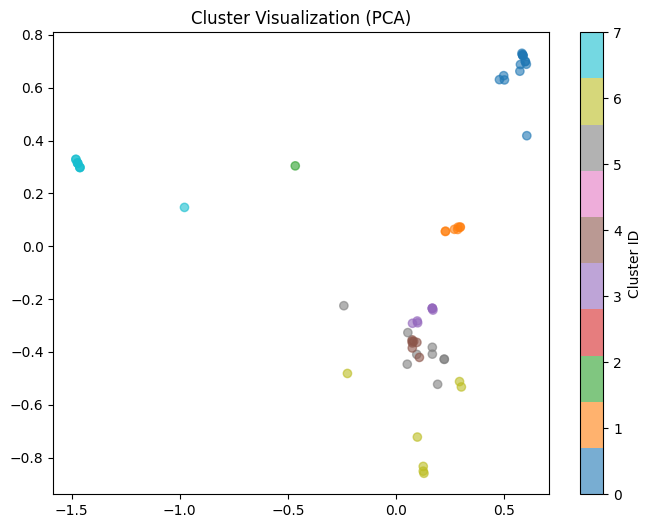

In [ ]:
def cluster_logs(df, features, out_path, n_clusters):
    """
    Cluster web server logs using feature embeddings and KMeans.

    Args:
        df (pd.DataFrame): DataFrame of log entries.
        features (np.ndarray): Feature matrix for clustering.
        out_path (str): Path for saving output CSV and TXT results.
        n_clusters (int): Number of clusters to create with KMeans.

    Returns:
        None
    """

    # Cluster embeddings
    bkm = BisectingKMeans(n_clusters=n_clusters, random_state=42, init="k-means++", n_init=5)
    labels = bkm.fit_predict(features)
    print(f"✅ Output of: labels")
    pprint(labels)

    # Group URLs by cluster
    df_label = df.copy()
    df_label["cluster"] = labels

    # Save clusters to a text file
    with open(f"{out_path}.txt", "w", encoding="utf-8") as f:
        for cluster_id in range(n_clusters):
            f.write(f"\nCluster {cluster_id}:\n")
            sample_rows = df_label[df_label["cluster"] == cluster_id]
            for _, row in sample_rows.iterrows():
                f.write(f"  {row['method']} {row['url']} [{row['status']}]\n")

    # Save results to CSV
    df_label.to_csv(out_path, index=False, encoding="utf-8")
    print(f"✅ Clustering results saved to: {out_path}")
    
    # evaluasi metrik
    metrics = evaluate_clusters(final_features, labels)
    print("Cluster Evaluation:", metrics)

    # visualisasi
    visualize_clusters(final_features, labels, "output/cluster_plot.png", False)
    
cluster_logs(df, final_features, output_dir, num_clusters)

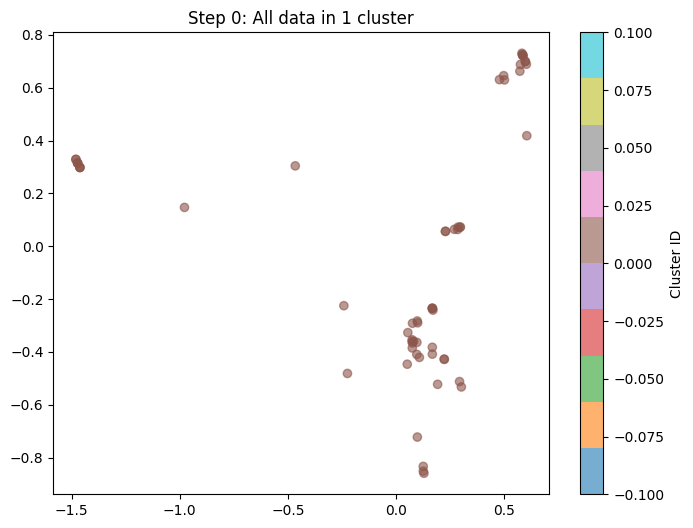

Step 0 Evaluation: {'silhouette': None, 'davies_bouldin': None, 'calinski_harabasz': None}


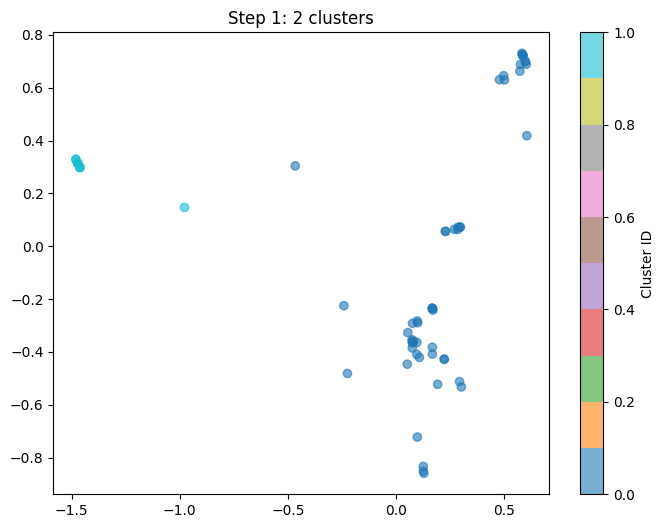

Step 1 Evaluation: {'silhouette': 0.35312135075264195, 'davies_bouldin': 0.8085916316045703, 'calinski_harabasz': 20.518166448715505}


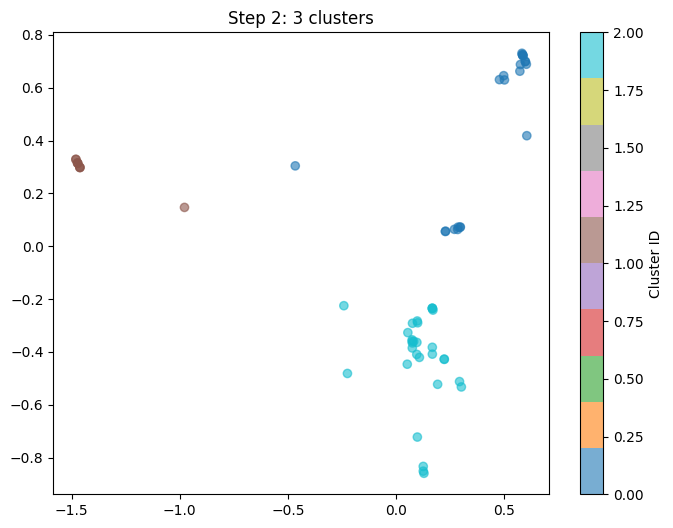

Step 2 Evaluation: {'silhouette': 0.3116295355281663, 'davies_bouldin': 1.48771315588231, 'calinski_harabasz': 19.553492070230607}


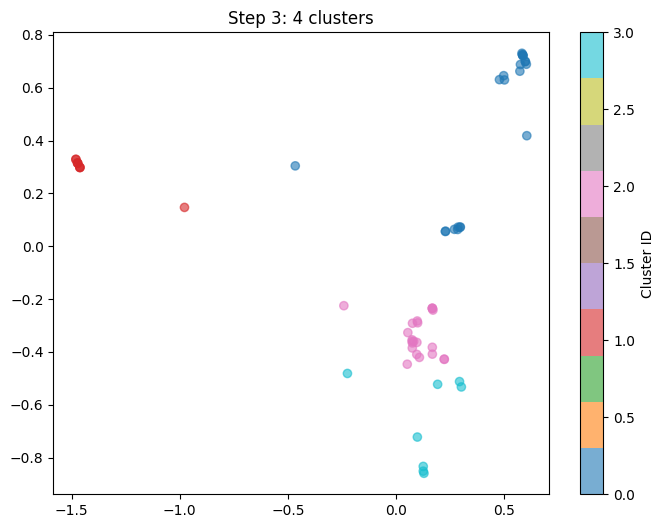

Step 3 Evaluation: {'silhouette': 0.3372891489079033, 'davies_bouldin': 1.400323780960528, 'calinski_harabasz': 18.143608468273616}


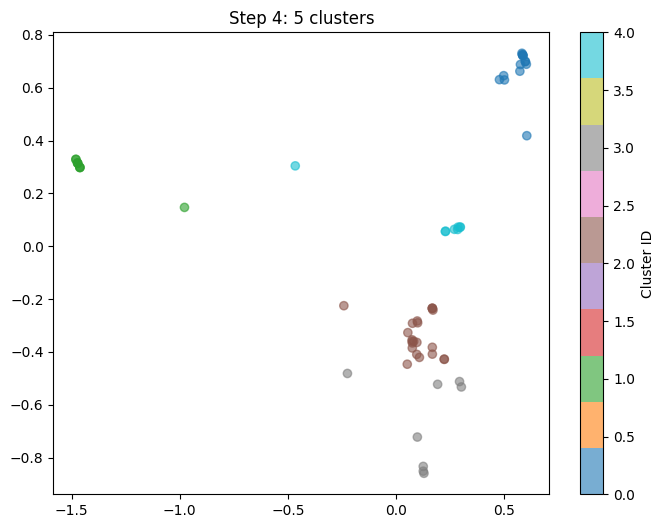

Step 4 Evaluation: {'silhouette': 0.4064916562036762, 'davies_bouldin': 1.3058122455711036, 'calinski_harabasz': 19.590332109453993}


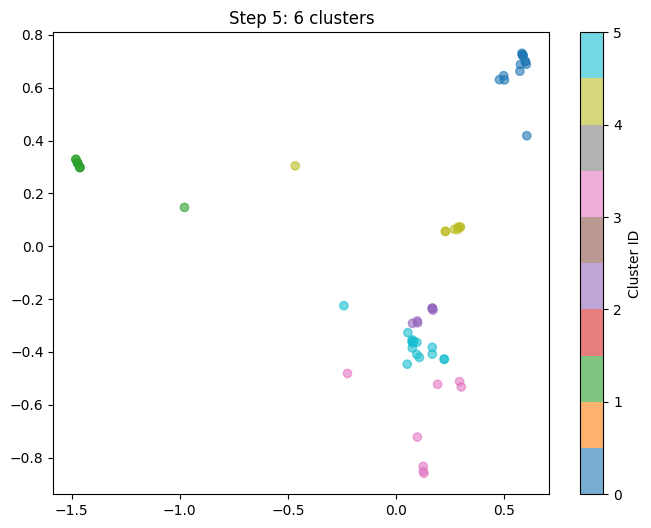

Step 5 Evaluation: {'silhouette': 0.43373339903937463, 'davies_bouldin': 1.2437216648230656, 'calinski_harabasz': 19.668666380874612}


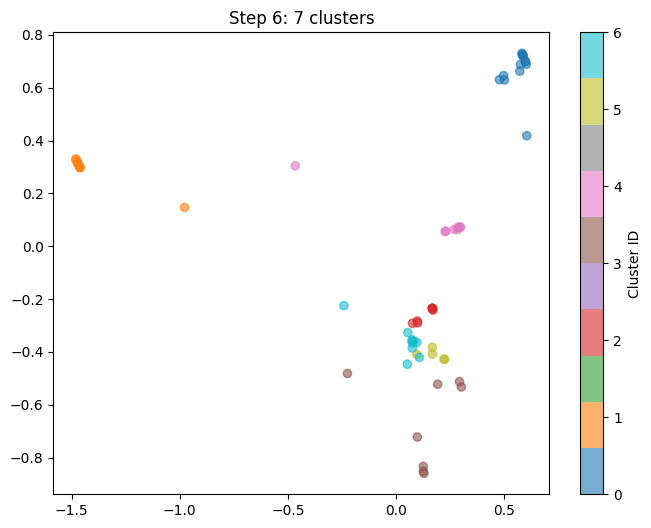

Step 6 Evaluation: {'silhouette': 0.47840635708342194, 'davies_bouldin': 1.0878470922053682, 'calinski_harabasz': 20.0476015112557}


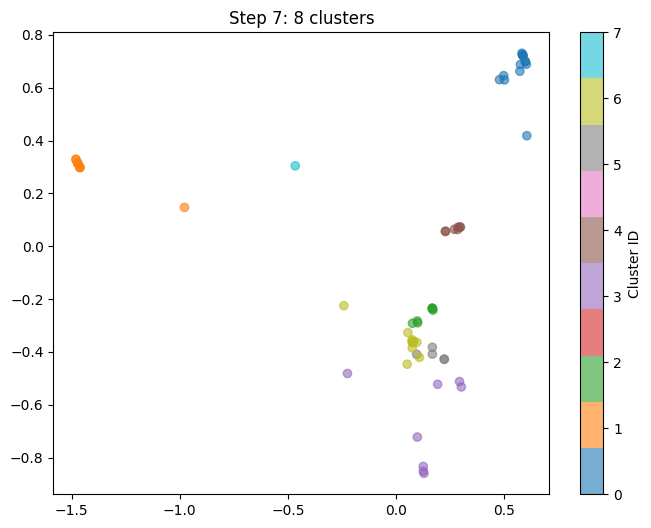

Step 7 Evaluation: {'silhouette': 0.4949592344368904, 'davies_bouldin': 0.9071297833331962, 'calinski_harabasz': 22.811559104972453}
✅ Manual BKM results saved to: ../outputs/sample.csv


In [ ]:
def cluster_logs_manual(df, features, out_path, n_clusters, strategy="biggest_inertia", random_state=42, n_init=5):
    """
    Cluster web server logs using manual Bisecting KMeans.
    Visualize + evaluate at each bisecting step.

    Args:
        df (pd.DataFrame): DataFrame of log entries.
        features (np.ndarray): Feature matrix for clustering.
        out_path (str): Path for saving output CSV and TXT results.
        n_clusters (int): Target number of clusters.
        strategy (str): 'biggest_inertia' or 'largest_cluster'.
        random_state (int): Random seed.
        n_init (int): Number of KMeans initializations.

    Returns:
        None
    """
    n_samples = len(features)
    clusters = {0: np.arange(n_samples)}
    current_labels = np.zeros(n_samples, dtype=int)
    cluster_inertias = {
        0: KMeans(n_clusters=1, random_state=random_state, n_init=n_init).fit(features).inertia_
    }

    # Step 0: semua data 1 cluster
    visualize_clusters(features, current_labels, save_plot=False, title="Step 0: All data in 1 cluster")

    metrics = evaluate_clusters(features, current_labels)
    print(f"Step 0 Evaluation: {metrics}")

    step = 1
    while len(clusters) < n_clusters:
        # 1. Pilih cluster target
        if strategy == "biggest_inertia":
            target_cid = max(cluster_inertias, key=cluster_inertias.get)
        elif strategy == "largest_cluster":
            target_cid = max(clusters, key=lambda c: len(clusters[c]))
        else:
            raise ValueError("strategy must be 'biggest_inertia' or 'largest_cluster'")

        target_idx = clusters[target_cid]

        # 2. Split cluster target
        km_split = KMeans(n_clusters=2, random_state=random_state, init="k-means++", n_init=n_init)
        split_labels = km_split.fit_predict(features[target_idx])

        # Buat cluster ID baru
        new_cid = max(clusters.keys()) + 1
        idx_left = target_idx[split_labels == 0]
        idx_right = target_idx[split_labels == 1]

        # Update struktur cluster
        clusters[target_cid] = idx_left
        clusters[new_cid] = idx_right

        # Update inertia cluster
        cluster_inertias[target_cid] = KMeans(n_clusters=1, random_state=random_state, init="k-means++", n_init=n_init).fit(features[idx_left]).inertia_
        cluster_inertias[new_cid] = KMeans(n_clusters=1, random_state=random_state, init="k-means++", n_init=n_init).fit(features[idx_right]).inertia_

        # Update labels global
        for i in idx_left:
            current_labels[i] = target_cid
        for i in idx_right:
            current_labels[i] = new_cid

        # 3. Visualisasi tahap ini
        visualize_clusters(features, current_labels, save_plot=False, title=f"Step {step}: {len(clusters)} clusters")

        # 4. Evaluasi tahap ini
        metrics = evaluate_clusters(features, current_labels)
        print(f"Step {step} Evaluation: {metrics}")

        step += 1

    # Setelah selesai → simpan hasil akhir
    df_label = df.copy()
    df_label["cluster"] = current_labels

    df_label.to_csv(out_path, index=False, encoding="utf-8")
    print(f"✅ Manual BKM results saved to: {out_path}")

    with open(f"{out_path}.txt", "w", encoding="utf-8") as f:
        for cluster_id in sorted(set(current_labels)):
            f.write(f"\nCluster {cluster_id}:\n")
            sample_rows = df_label[df_label["cluster"] == cluster_id]
            for _, row in sample_rows.iterrows():
                f.write(f"  {row['method']} {row['url']} [{row['status']}]\n")

cluster_logs_manual(df, final_features, output_dir, n_clusters=num_clusters)